<a href="https://colab.research.google.com/github/RVaishnavi12/Musicology/blob/main/GenerationandGenre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Generate music with RNN

##Setup

`pretty_midi` library is used to create and parse MIDI files, and `pyfluidsynth` is used for generating audio playback in Colab.

In [2]:
!sudo apt install -y fluidsynth

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libfluidsynth2 libinstpatch-1.0-2 qsynth
  timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs timidity jackd musescore
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libfluidsynth2 libinstpatch-1.0-2 qsynth
  timgm6mb-soundfont
0 upgraded, 6 newly installed, 0 to remove and 24 not upgraded.
Need to get 126 MB of archives.
After this operation, 157 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fluid-soundfont-gm all 3.1-5.1 [119 MB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 libinstpatch-1.0-2 amd64 1.1.2-2build1 [238 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 timgm6mb-soundfont all 1.3-3 [5,420 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal/universe amd64 libfluidsynth2 amd64 2.1.1-2 [

In [3]:
!pip install --upgrade pyfluidsynth

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install pretty_midi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 50.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 7.2 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592289 sha256=3847b01f4ffd3a1509ad11028eb02a22ee0976b022a46820ee91c01d79ca5728
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi


In [5]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

In [6]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

## Download the adl-piano-midi dataset

In [7]:
data_dir = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/adl-piano-midi')

In [8]:
filenames = glob.glob(str(data_dir/'**/**/**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 11079


In [9]:
#filenames = glob.glob(str(data_dir/'**/**/*.mid*'))
#print('Number of files:', len(filenames))

##Process a MIDI file

 ```pretty_midi``` is used to parse a single MIDI file and inspect the format of the notes.

In [10]:
sample_file = filenames[1]
print(sample_file)

/content/drive/MyDrive/Colab Notebooks/adl-piano-midi/Religious/Worship/The Glorious Unseen/Sweet_ Sweet Sound.mid


Generate a `PrettyMIDI` object for the sample MIDI file.

In [11]:
pm = pretty_midi.PrettyMIDI(sample_file)

Play the sample file. (The playback widget may take several seconds to load.)

In [12]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [13]:
display_audio(pm)

Identify the kinds of instrument(s) used.

In [14]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


In [15]:
for instrument in pm.instruments: print(pretty_midi.program_to_instrument_name(instrument.program))

Acoustic Grand Piano


##Extract notes

In [16]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=64, note_name=E4, duration=0.5091
1: pitch=63, note_name=D#4, duration=0.4940
2: pitch=64, note_name=E4, duration=0.5292
3: pitch=66, note_name=F#4, duration=0.4940
4: pitch=64, note_name=E4, duration=0.4536
5: pitch=63, note_name=D#4, duration=0.5091
6: pitch=64, note_name=E4, duration=0.4889
7: pitch=66, note_name=F#4, duration=0.5141
8: pitch=64, note_name=E4, duration=0.4940
9: pitch=63, note_name=D#4, duration=0.4687


Three variables are used to represent a note when training the model: `pitch`, `step` and `duration`. 
*   The `pitch` is the perceptual quality of the sound as a MIDI note number. 
*   The `step` is the time elapsed from the previous note or start of the track.
*   The `duration` is how long the note will be playing in seconds and is the difference between the note end and note start times.

Extract the notes fron the sample MIDI file.

In [17]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [18]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,64,3.87096,4.380032,0.00000,0.509072
1,63,4.35483,4.848781,0.48387,0.493951
2,64,4.83870,5.367933,0.48387,0.529233
3,66,5.32257,5.816521,0.48387,0.493951
4,64,5.80644,6.260068,0.48387,0.453628


It is easier to interpret the note names rather than the pitches, so the function below is used to convert from the numeric pitch values to note names. 
The note name shows the type of note, accidental and octave number
(e.g. C#4). 

In [19]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['E4', 'D#4', 'E4', 'F#4', 'E4', 'D#4', 'E4', 'F#4', 'E4', 'D#4'],
      dtype='<U3')

Plot the note pitch, start and end across the length of the track(i.e. piano roll) to visualize the musical piece. 
Start with the first 100 notes

In [20]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

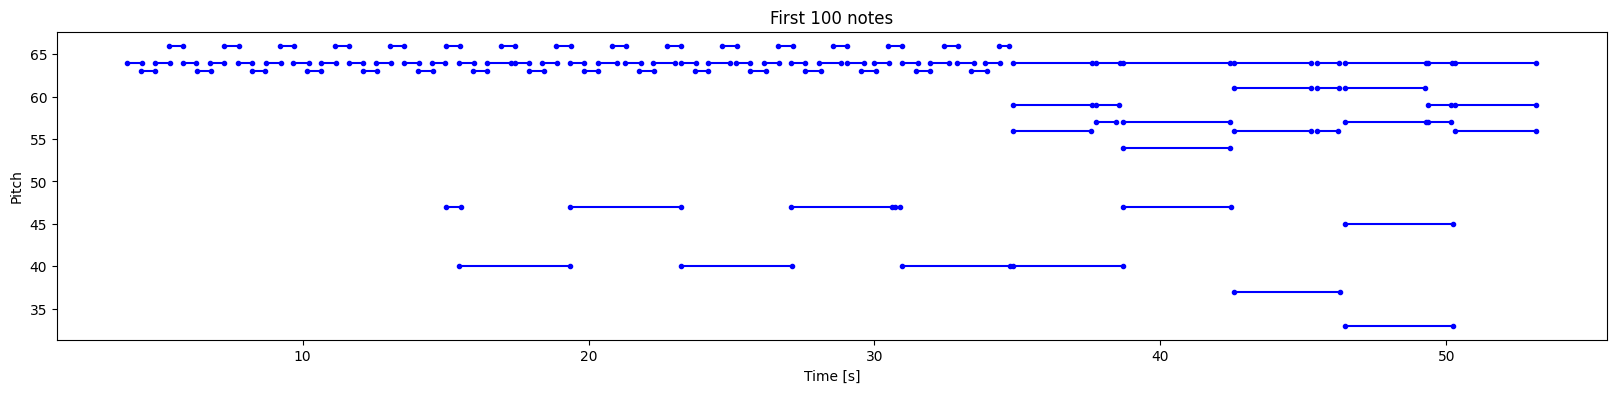

In [21]:
plot_piano_roll(raw_notes, count=100)

Plot the notes for the entire track.

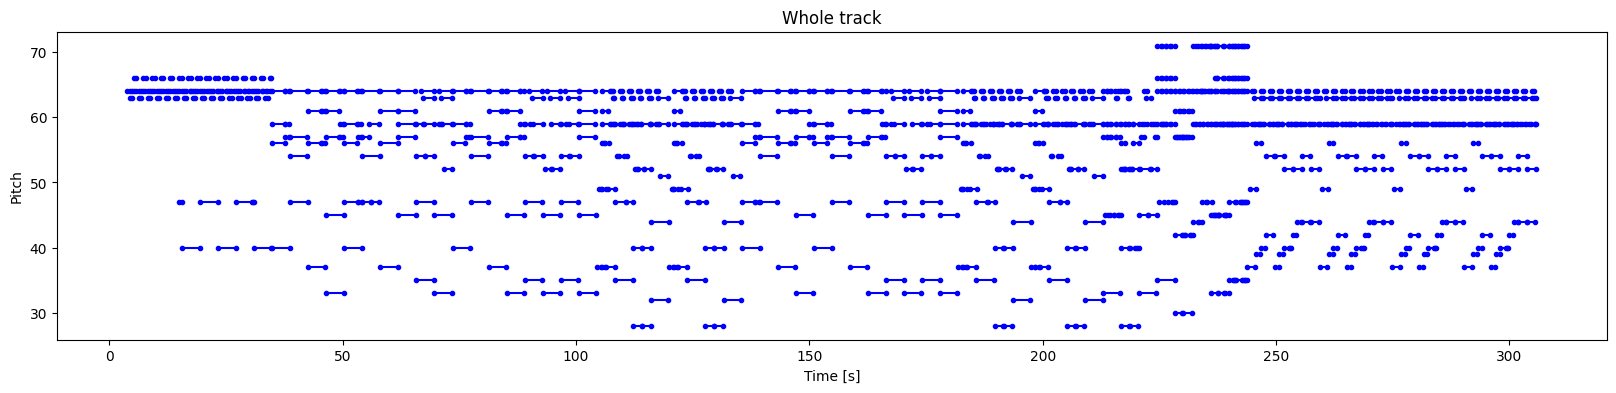

In [22]:
plot_piano_roll(raw_notes)

Check the distribution of each nte variable.

In [23]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))
  
  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

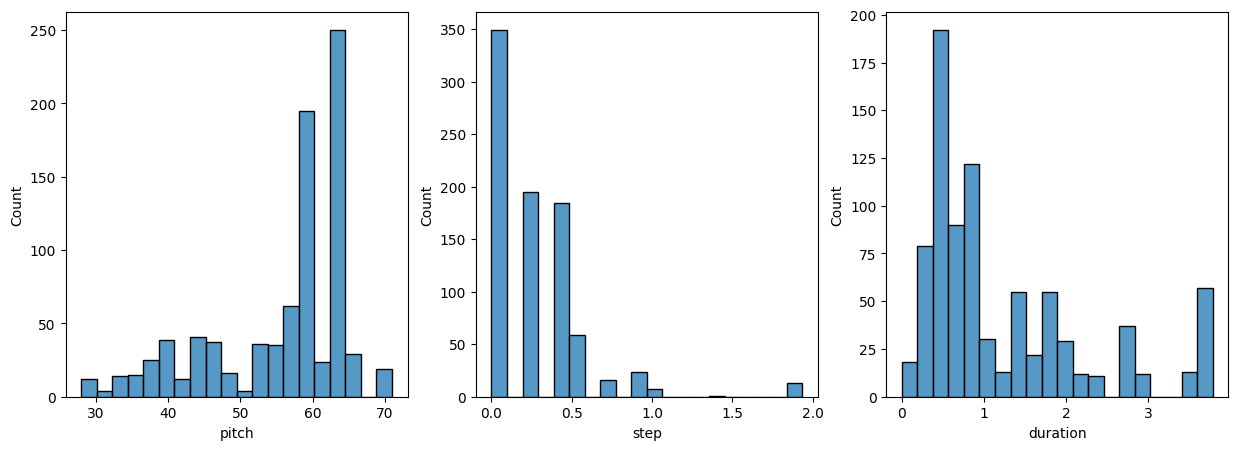

In [24]:
plot_distributions(raw_notes)

##Create a MIDI file

Generate your own MIDI file from a list of notes.

In [25]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write("/content/drive/MyDrive/Colab Notebooks/Test/"+out_file)
  return pm

In [26]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

Play the generated MIDI file and see if there is any difference.

In [27]:
display_audio(example_pm)

##Create the training dataset

Training dataset is created by extracting notes from the MIDI files.

In [28]:
num_files = 10
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [29]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 8926


A `tf.data.Dataset` is created from the
parsed notes.

In [30]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [31]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

The model is trained on batches of sequences of notes. Each example will consist of a sequence of notes as the input features, and the next note as the label. In this way, the model will be trained to predict the next note in a sequence.

In [32]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)
  
  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

The size of the vocabulary (`vocab_size`) is set to 128 representing all the pitches supported by `pretty_midi`.

In [33]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

The shape of the dataset is ```(100,1)```, meaning that the model will take 100 notes as input, and learn to predict the following note as output.

In [34]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.671875   0.         0.18852467]
 [0.6484375  0.12295087 0.14344269]
 [0.6328125  0.12295088 0.18442631]
 [0.6484375  0.24590175 0.20491812]
 [0.671875   0.         0.24590175]
 [0.6328125  0.24590175 0.24590175]
 [0.578125   0.24590175 0.24590175]
 [0.5390625  0.24590175 0.50614777]
 [0.5546875  0.4918035  2.78073896]
 [0.484375   3.4426245  3.43237859]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=64.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.0>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=3.514345843749993>}


Batch the examples, and configure the dataset for performance.

In [35]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [36]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

##Create and train the model

The model will have three outputs, one for each note variable. For `step` and `duration`, a custom loss function is used based on mean squared error that encourages the model to output non-negative values.


In [37]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [38]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25, 3)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 128)          67584       ['input_1[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm[0][0]']                   
                                                                                                  
 pitch (Dense)                  (None, 128)          16512       ['lstm[0][0]']                   
                                                                                              

The `pitch` loss is significantly greater than the `step` and `duration` losses this can be seen by testing the `model.evaluate` function. 
`loss` is the total loss computed by summing all the other losses and is currently dominated by the `pitch` loss.

In [39]:
losses = model.evaluate(train_ds, return_dict=True)
losses

139/139 [==============================] - 4s 17ms/step - loss: 8.6805 - duration_loss: 1.4566 - pitch_loss: 4.8791 - step_loss: 2.3448


{'loss': 8.680534362792969,
 'duration_loss': 1.4566038846969604,
 'pitch_loss': 4.879096508026123,
 'step_loss': 2.3448328971862793}

`loss_weights` argument to compile is a way to balance this.

In [40]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

The `loss` then becomes the weighted sum of the individual losses.

In [41]:
model.evaluate(train_ds, return_dict=True)

139/139 [==============================] - 3s 11ms/step - loss: 4.0454 - duration_loss: 1.4566 - pitch_loss: 4.8791 - step_loss: 2.3448


{'loss': 4.04539155960083,
 'duration_loss': 1.4566038846969604,
 'pitch_loss': 4.879096508026123,
 'step_loss': 2.3448328971862793}

##Train the model

In [42]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [ ]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
139/139 [==============================] - 6s 33ms/step - loss: 2.5702 - duration_loss: 0.3264 - pitch_loss: 3.9363 - step_loss: 2.0470
Epoch 2/50
139/139 [==============================] - 6s 40ms/step - loss: 2.4822 - duration_loss: 0.2808 - pitch_loss: 3.6102 - step_loss: 2.0209
Epoch 3/50
139/139 [==============================] - 4s 27ms/step - loss: 2.4613 - duration_loss: 0.2765 - pitch_loss: 3.5483 - step_loss: 2.0074
Epoch 4/50
139/139 [==============================] - 5s 34ms/step - loss: 2.4398 - duration_loss: 0.2699 - pitch_loss: 3.5064 - step_loss: 1.9946
Epoch 5/50
139/139 [==============================] - 4s 28ms/step - loss: 2.4306 - duration_loss: 0.2697 - pitch_loss: 3.4786 - step_loss: 1.9870
Epoch 6/50
139/139 [==============================] - 5s 35ms/step - loss: 2.4248 - duration_loss: 0.2666 - pitch_loss: 3.4727 - step_loss: 1.9846
Epoch 7/50
139/139 [==============================] - 4s 27ms/step - loss: 2.4119 - duration_loss: 0.2609 - pitch_loss

In [ ]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [ ]:
model.summary()

In [ ]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

##Generate notes 

In [ ]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
  """Generates a note IDs using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']
 
  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

Now generate some notes - `next_notes`.

In [ ]:
def notesGenerator(temperature, num_predictions, raw_notes):

  temperature = 2.0
  num_predictions = 120

  sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

  # The initial sequence of notes; pitch is normalized similar to training
  # sequences
  input_notes = (
      sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

  generated_notes = []
  prev_start = 0
  for _ in range(num_predictions):
    pitch, step, duration = predict_next_note(input_notes, model, temperature)
    start = prev_start + step
    end = start + duration
    input_note = (pitch, step, duration)
    generated_notes.append((*input_note, start, end))
    input_notes = np.delete(input_notes, 0, axis=0)
    input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
    prev_start = start

  generated_notes = pd.DataFrame(
      generated_notes, columns=(*key_order, 'start', 'end'))
  
  return generated_notes
  
def saveAndGenerateMIDI(generated_notes,instrument_name="Acoustic Grand Piano", out_file = 'output.mid'):
  # if out_file.split('.')
  out_pm = notes_to_midi(
      generated_notes, out_file=out_file, instrument_name=instrument_name)
  return out_pm

Save and generate MIDI(generated_notes)

In [ ]:
import random

# temperature, num_predictions = map(int,input("input Temprature and number of predictions to generate: ").split())
temperature, num_predictions = map(int,("20 52").split())

# raw_notes = midi_to_notes(sample_file)

while True:

  #generate notes from random file from filenames 
  random_file = filenames[random.randrange(len(filenames))]
  raw_notes = midi_to_notes(random_file)
  print(random_file)

  # Create a function to view audio file in while loop or Function
  display_audio(saveAndGenerateMIDI(raw_notes)) #does not display audio

  user_choice = input("Do you want to generate notes from above file: ").lower()



  if user_choice == "yes":
    generated_notes = notesGenerator(temperature, num_predictions,raw_notes)
    break
  elif user_choice == "no":
    continue
  else:
    print("Please provide valid output")
# display_audio(pretty_midi.PrettyMIDI(filenames[random.randint(0,450)]))

display_audio(saveAndGenerateMIDI(generated_notes))

In [ ]:
# generate n number of random audio files

import random

temperature, num_predictions = map(int,("20 52").split())


# raw_notes = midi_to_notes(sample_file)
n=10
#n=25
for _ in range(n):

  #generate notes from random file from filenames 
  random_file = filenames[random.randrange(len(filenames))]
  raw_notes = midi_to_notes(random_file)
  print(random_file)

  # Create a function to view audio file in while loop or Function
  display_audio(saveAndGenerateMIDI(raw_notes)) #does not display audio



  generated_notes = notesGenerator(temperature, num_predictions,raw_notes)
  

  display_audio(saveAndGenerateMIDI(generated_notes, out_file=f"GeneratedAudio{_}.midi"))

In [ ]:
generated_notes.head(10)

In [ ]:
def saveAndGenerateMIDI(generated_notes,instrument_name="Acoustic Grand Piano", out_file = 'output.mid'):
  out_pm = notes_to_midi(
      generated_notes, out_file=out_file, instrument_name=instrument_name)
  return out_pm

display_audio(saveAndGenerateMIDI(generated_notes))

Visualize the generated notes.

In [ ]:
plot_piano_roll(generated_notes)

In [ ]:
plot_distributions(generated_notes)

In [ ]:
!pip install pydub

In [ ]:
# convert Midi to wav
!apt install fluidsynth
!wget https://github.com/FluidSynth/fluid-soundfont/releases/download/v3.1/FluidR3_GM.sf2 

In [ ]:
import subprocess

def midi_to_wav(midi_filename, wav_filename):
    """
    Convert a MIDI file to a WAV file using FluidSynth.
    """
    subprocess.call(['fluidsynth', '-F', wav_filename, '-ni', 'FluidR3_GM.sf2', midi_filename])

midi_to_wav("/content/generatedAudio7.midi", "/content/wav_file.wav")

In [ ]:
!pip install midi2audio
!pip install mido

In [ ]:
from midi2audio import FluidSynth
# Play MIDI:
FluidSynth().midi_to_audio('/content/generatedAudio2.mid', 'output.wav')
# FluidSynth().play_midi('input.mid')

In [ ]:
from midi2audio import FluidSynth
# Play MIDI:
FluidSynth().midi_to_audio('/content/generatedAudio2.mid', 'output.wav')
# FluidSynth().play_midi('input.mid')

In [ ]:
type(pm)

##Genre Classification using KNN

In [ ]:
!pip install python_speech_features

In [ ]:
from python_speech_features import mfcc
import scipy.io.wavfile as wav
import numpy as np

from tempfile import TemporaryFile

import os
import pickle
import random
import operator

import math

In [ ]:
# function to get the distance between feature vecotrs and find neighbors
def getNeighbors(trainingSet, instance, k):
    distances = []
    for x in range(len(trainingSet)):
        dist = distance(trainingSet[x], instance, k) + distance(instance, trainingSet[x], k)
        distances.append((trainingSet[x][2], dist))

    distances.sort(key=operator.itemgetter(1))
    neighbors = []
    for x in range(k):
        neighbors.append(distances[x][0])
    
    return neighbors

In [ ]:
# identify the class of the instance
def nearestClass(neighbors):
    classVote = {}

    for x in range(len(neighbors)):
        response = neighbors[x]
        if response in classVote:
            classVote[response] += 1
        else:
            classVote[response] = 1

    sorter = sorted(classVote.items(), key = operator.itemgetter(1), reverse=True)

    return sorter[0][0]

In [ ]:
# function to evaluate the model
def getAccuracy(testSet, prediction):
    correct = 0
    for x in range(len(testSet)):
        if testSet[x][-1] == predictions[x]:
            correct += 1
    
    return (1.0 * correct) / len(testSet)

In [ ]:
# directory that holds the wav files
directory = r"/content/drive/MyDrive/Colab Notebooks/Data/genres_original/"

# binary file where we will collect all the features extracted using mfcc (Mel Frequency Cepstral Coefficients)
f = open("my.dat", 'wb')

i = 0

for folder in os.listdir(directory):
    i += 1
    if i == 11:
        break
    for file in os.listdir(directory+folder):        
        try:
            (rate, sig) = wav.read(directory+folder+"/"+file)
            mfcc_feat = mfcc(sig, rate, winlen=0.020, appendEnergy=False)
            covariance = np.cov(np.matrix.transpose(mfcc_feat))
            mean_matrix = mfcc_feat.mean(0)
            feature = (mean_matrix, covariance, i)
            pickle.dump(feature, f)
        except Exception as e:
            print('Got an exception: ', e, ' in folder: ', folder, ' filename: ', file)        

f.close()

In [ ]:
# Split the dataset into training and testing sets respectively
dataset = []

def loadDataset(filename, split, trSet, teSet):
    with open('my.dat', 'rb') as f:
        while True:
            try:
                dataset.append(pickle.load(f))
            except EOFError:
                f.close()
                break
    for x in range(len(dataset)):
        if random.random() < split:
            trSet.append(dataset[x])
        else:
            teSet.append(dataset[x])
trainingSet = []
testSet = []
loadDataset('my.dat', 0.66, trainingSet, testSet)

In [ ]:
def distance(instance1 , instance2 , k ):
    distance =0 
    mm1 = instance1[0] 
    cm1 = instance1[1]
    mm2 = instance2[0]
    cm2 = instance2[1]
    distance = np.trace(np.dot(np.linalg.inv(cm2), cm1)) 
    distance+=(np.dot(np.dot((mm2-mm1).transpose() , np.linalg.inv(cm2)) , mm2-mm1 )) 
    distance+= np.log(np.linalg.det(cm2)) - np.log(np.linalg.det(cm1))
    distance-= k
    return distance

In [ ]:
# making predictions using KNN
leng = len(testSet)
predictions = []
for x in range(leng):
    predictions.append(nearestClass(getNeighbors(trainingSet, testSet[x], 5)))

accuracy1 = getAccuracy(testSet, predictions)
print(accuracy1)

In [ ]:
from collections import defaultdict
results = defaultdict(int)

directory = r"/content/drive/MyDrive/Colab Notebooks/Data/genres_original/"
i = 1
for folder in os.listdir(directory):
    results[i] = folder
    i += 1

In [ ]:
def getNeighbors(trainingSet, instance, k):
    distances = []
    # print("instance",instance)
    # print(trainingSet)
    for x in range(len(trainingSet)):
        dist = distance(trainingSet[x], instance, k) + distance(instance, trainingSet[x], k)
        distances.append((trainingSet[x][2], dist))

    distances.sort(key=operator.itemgetter(1))
    neighbors = []
    for x in range(k):
        neighbors.append(distances[x][0])
    
    return neighbors

In [ ]:
def feature_generation(test_file):

  (rate, sig) = wav.read(test_file)
  mfcc_feat = mfcc(sig, rate, winlen=0.020, appendEnergy=False)
  covariance = np.cov(np.matrix.transpose(mfcc_feat))
  mean_matrix = mfcc_feat.mean(0)
  feature = (mean_matrix, covariance, i)
  return feature

In [ ]:
!apt install fluidsynth
!wget https://github.com/FluidSynth/fluid-soundfont/releases/download/v3.1/FluidR3_GM.sf2 

In [ ]:
import subprocess

def midi_to_wav(midi_filename, wav_filename):
    """
    Convert a MIDI file to a WAV file using FluidSynth.
    """
    subprocess.call(['fluidsynth', '-F', wav_filename, '-ni', 'FluidR3_GM.sf2', midi_filename])


midi_to_wav("/content/generatedAudio7.midi", "/content/wav_file.wav")

In [ ]:
# "/content/drive/MyDrive/Colab Notebooks/Test/test2.wav"
test_dir = r"/content/drive/MyDrive/Colab Notebooks/Test/"
test_file = test_dir + "test1.wav"
for file in os.listdir(test_dir):
  print(file)
  a=test_dir+file
  if file.split('.')[-1] == 'midi':
    main_file =test_dir+ file.split(".")[0] + ".wav"
    midi_to_wav(a,main_file)
    pred = nearestClass(getNeighbors(dataset, feature_generation(main_file), 5))
    print (results[pred])

In [ ]:
key={'pop':'Pop', 'jazz':'Jazz', 'ambient':'Ambient', 'blues':'Blues', 'children':'Children', 'classical':'Classical', 'country':'Country', 'electronic':'Electronic', 'folk':'Folk', 'latin':'Latin', 'rap':'Rap', 'reggae':'Reggae', 'religious':'Religious', 'rock':'Rock', 'soul':'Soul'}

while True:

  input_genre = input("""
  Select from following genre
  1. Jazz
  2. Pop
  3. Ambient
  4. Blues
  5. Children
  6. Classical
  7. Country
  8. Electronic
  9. Folk
  10. Latin
  11. Rap
  12. Reggae
  13. Religious
  14. Rock
  15. Soul
  """).lower()

  if input_genre in {'jazz', 'pop', 'ambient', 'blues', 'children', 'classical', 'country', 'electronic', 'folk', 'latin', 'rap', 'reggae', 'religious', 'rock', 'soul'}:

    

    data_dir = pathlib.Path(f'/content/drive/MyDrive/Colab Notebooks/adl-piano-midi/{key[input_genre]}')
    filenames = glob.glob(str(data_dir/'**/**/*.mid*'))
    #filenames = glob.glob(str(data_dir/'**/**/**/*.mid*'))

    print(len(filenames), filenames)
    sample_file = filenames[random.randint(0, len(filenames)-1)]
    
    pm = pretty_midi.PrettyMIDI(sample_file)
    temperature, num_predictions = map(int,("20 52").split())

    #generate notes from base file from filenames 
    raw_notes = midi_to_notes(sample_file)

    # Create a function to view audio file in while loop or Function
    display_audio(saveAndGenerateMIDI(raw_notes))

    generated_notes = notesGenerator(temperature, num_predictions,raw_notes)

    break


    pass
  else:
    print("Please enter a valid genre")
display_audio(pm)
